# MCMC Tutorial

**Authors:** John Letey, Mingxuan Zhang, H. Nihar Nandan

<br>

## Generate Synthetic Data


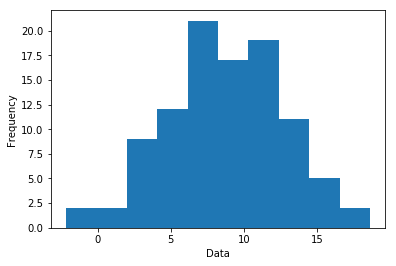

In [3]:
# Set up!
ustar = 8
sstar = 4

data_meas = generate_synthetic_data(ustar, sstar)

## Likelihood Function



In [4]:
def likelihood(parameters, data_meas=data_meas):
    u, s = parameters                                                 # unpack the parameters
    prod = 1                                                          # initilize the product to 1
    for i in range(len(data_meas)):                                   # calculate the pdf for each data point 
        prod += np.log(stats.norm.pdf(x=data_meas[i], loc=u, scale=s))# calculate the pdf (probability density function)
    return prod                                                       # return the final product

## Prior Distribution


In [5]:
def prior(parameters):
    u, s = parameters                # unpack the parameters
    return -np.inf if s > 100 or s < 0 else np.log(stats.norm.pdf(x=u, loc=0, scale=100)*(1/100))

## Posterior Distribution/Posterior Score


In [6]:
def logpost(parameters, data_meas=data_meas):
    L = likelihood(parameters, data_meas) # calculate the likelihood
    pi = prior(parameters)                            # calculate the prior
    return L + pi                             # return the log of the posterior

## Adaptive Metropolis-Hastings Algorithm


In [7]:
# set up some parameters for adaptive metropolis algorithm

eps = 0.0001

d = 2                                                                                                                                                                                                                                                                                                         

I_d = np.identity(d)

S_d = (2.4)**2/2

In [8]:
# update the covariance matrix by using this function

def update_cov(X, d=2, s_d=S_d, eps=0.0001, i_d=I_d):
    cov = np.cov(X)
    return s_d*cov + i_d*eps*s_d

In [9]:
# First, let's set up some classes for our Metropolis-Hastings algorithm

class State: # This is the class for the state in Markov chain
    def __init__(self, state, value):
        self.state = state # The current state
        self.value = value # The corresponding log-posterior score for the current state

class ProblemMCMC: # This is the class to set the specific problem we want to solve by using Metropolis-Hastings algorithm
    def __init__(self, initial, logposterior, stepsize, data_measa, t0=1):
        self.current = initial # The initial state
        self.logpost = logposterior # The log-posterior function
        self.stepsize = stepsize # The covariance matrix to draw samples from mulitvariare normal distirbution
        self.data_meas = data_meas
        self.t0 = t0       # the choice for the length of the initial segment for adaptive mcmc
        
    def random_move(self, t, X): # This is the function to pick a random move by drawing from a multivariate normal distribution
        if (t <= self.t0):
            next_move = stats.multivariate_normal.rvs(self.current.state, self.stepsize)
        else:
            cov = update_cov(X)
            next_move = stats.multivariate_normal.rvs(self.current.state, cov)
        return next_move, self.logpost(next_move, self.data_meas)

In [20]:
def Adaptive_mcmc(problem, n_iter):
    
    # want to keep growing these lists to track the parameter estimates
    u = [problem.current.state[0]]
    s = [problem.current.state[1]]
    lpost = [problem.current.value]
    n_accept = 0
    S = 0
    
    #bar = pyprind.ProgBar(n_iter, title='\nRunning adaptive algorithm on '+sequence_title, bar_char='#')
    for t in range(n_iter-1):
        S += 1
        nextMove, nextValue = problem.random_move(t, [u, s])
        delta_obj = np.exp(nextValue - lpost[-1])
        if delta_obj > 1:
            # the proposed move is an improvement, so accept w.p. 1
            n_accept += 1
            u.append(nextMove[0])
            s.append(nextMove[1])
            lpost.append(nextValue)
            problem.current.state = nextMove
            problem.current.value = nextValue
        else:
            # the proposed move is worse; accept with probability exp[delta_obj/T]
            p_accept = delta_obj
            accept = np.random.choice([True, False], p=[p_accept, 1-p_accept])
            if accept:
                n_accept += 1
                u.append(nextMove[0])
                s.append(nextMove[1])
                lpost.append(nextValue)
                problem.current.state = nextMove
                problem.current.value = nextValue
            else:
                u.append(u[-1])
                s.append(s[-1])
                lpost.append(lpost[-1])
        
        #bar.update()

    return (u, s, lpost, n_accept/S)

In [22]:
u, s, ar = sequences_generator(mcmc=Adaptive_mcmc, problem=ProblemMCMC, m=3)

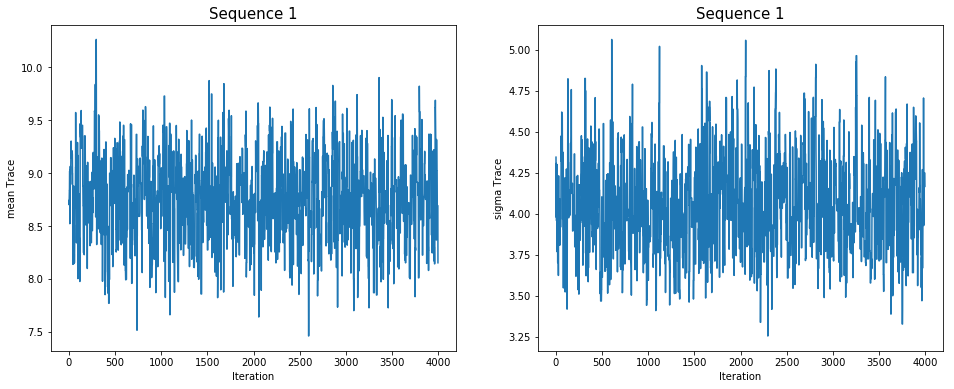

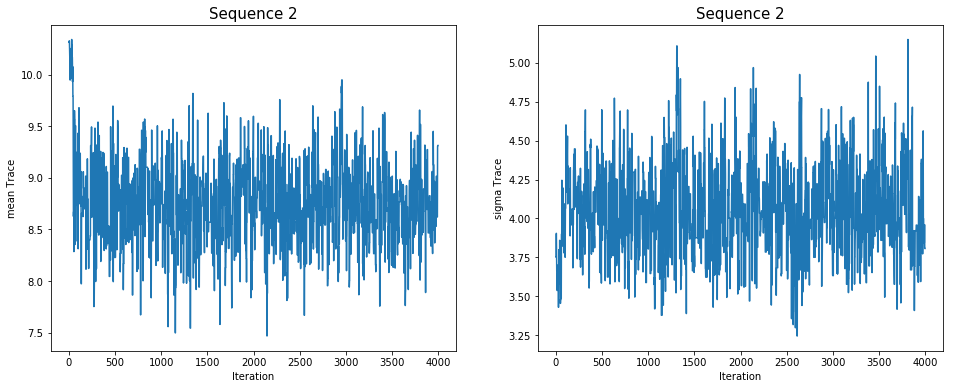

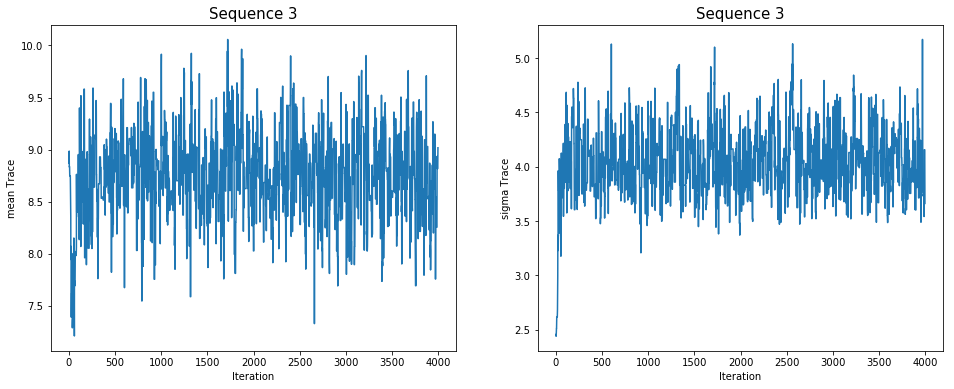

In [23]:
plot_sequences(u, s)

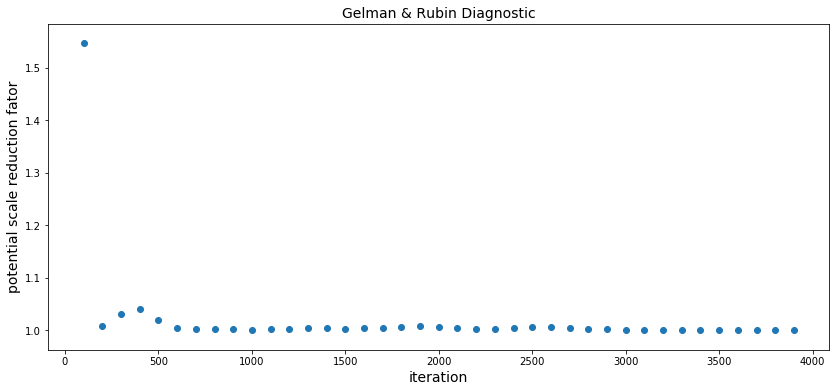

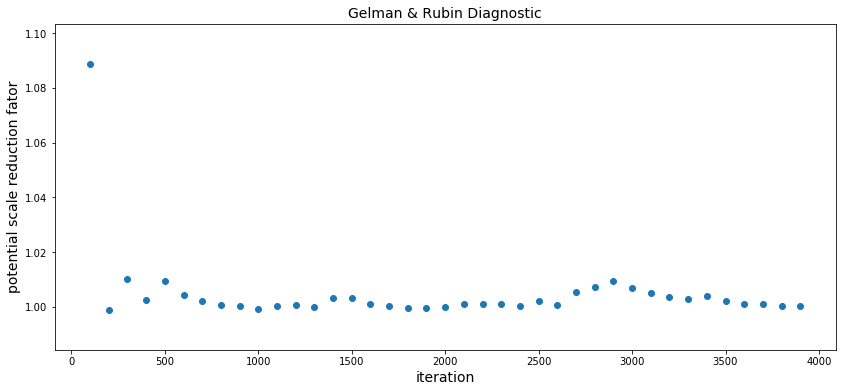

In [29]:
GR_u = GR_diag(u)
GR_s = GR_diag(s)

## Convergence/Stationarity Diagnostics



In [24]:
def GR_diag(parameter, interval=100, start=100, plot=True):
    end = len(parameter[0])
    m = len(parameter)
    GR_result = []
    x_range = []
    for n in range(start, end, interval):
        x_range.append(n)
        sequences = []
        for i in range(m):
            sequences.append(parameter[i][:n])
        GR_result.append(psrf(sequences))
    if plot:
        plt.figure(figsize=(14, 6))
        plt.scatter(x=x_range, y=GR_result)
        plt.xlabel('iteration', fontsize=14)
        plt.ylabel('potential scale reduction fator', fontsize=14)
        plt.title('Gelman & Rubin Diagnostic', fontsize=14)
        plt.show()
    return GR_result

def psrf(sequences):
    u, s, m = [], [], len(sequences)
    last_n = [sequences[i][int(len(sequences[i])/2):] for i in range(m)]
    n = len(last_n[0])
    for j in range(m):
        u.append(np.mean(last_n[j]))
        var = 0
        for i in range(n):
            var += (last_n[j][i]-u[-1])**2
        s.append(var/(n-1)) 
    W, B, U = sum(s)/m, 0, np.mean(u)
    for j in range(m):
        B += (u[j] - U)**2
    B = (B*n)/(m-1)
    Var = (1-(1/n))*W + (B/n)
    return np.sqrt(Var/W)

## Thinning



In [15]:
def ACF(X, interval=100):
    N = len(X)
    acf = []
    x_range = []
    for a in range(0, 100, interval):
        x_range.append(a)
        acf.append(np.corrcoef(X[a:], X[:N-a])[0][1])
    return acf, x_range

In [16]:
def plot_acf(acf, x_ran):
    plt.stem(x_ran, acf)
    plt.xlabel('lag')
    plt.ylabel('acf values')
    plt.show()

## Helper functions:

In [1]:
# All of our imports that we need

import pandas as pd
import numpy as np
import scipy.stats as stats
import sys
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Function to generate synthetic data (and plot it)
def generate_synthetic_data(ustar, sstar, plot=True):
    np.random.seed(3202) # set the seed for random sampling.
    data_meas = stats.norm.rvs(loc=ustar, scale=sstar, size=100)
    if plot:
        plt.figure(figsize=(6, 4))
        plt.hist(data_meas)
        plt.xlabel('Data', fontsize=10)
        plt.ylabel('Frequency', fontsize=10)
    return data_meas

In [21]:
def sequences_generator(mcmc, problem, m, t0=1, stepsize=[0.003, 0.02], n_iter=4000, data_meas=data_meas, logpost=logpost):
    problems = []
    bestfit = (np.mean(data_meas), np.std(data_meas))
    for i in range(m):
        # we can generate different initial conditions for each sequence
        theta = stats.multivariate_normal.rvs([bestfit[0], bestfit[1]], [1, 1])
        # set the state for the mcmc problem
        state = State(theta, logpost(theta, data_meas))
        problems.append(problem(state, logpost, stepsize, data_meas, t0))
    us = []
    ss = []
    ar = []
    #print("Running MCMC algorithm", file=sys.stderr)
    for i in range(m):
        u, s, l, r = mcmc(problems[i], n_iter)
        us.append(u)
        ss.append(s)
        ar.append(r)
    return us, ss, ar

In [12]:
def plot_sequences(u, s):
    m = len(u)
    for i in range(m):
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
        ax[0].plot(u[i])
        ax[0].set_xlabel("Iteration")
        ax[0].set_ylabel("mean Trace")
        ax[0].set_title("Sequence {}".format(i+1), fontsize=15)
        ax[1].plot(s[i])
        ax[1].set_xlabel("Iteration")
        ax[1].set_ylabel("sigma Trace")
        ax[1].set_title("Sequence {}".format(i+1), fontsize=15)
        #fig.savefig("traces/trace_sequence_"+str(i+1)+".png")